This is a tutorial to use the flip package: https://github.com/corentinravoux/flip \
It is self-contained and can be used in google collab or on your environement \
All the data used are subsampled version of a simulation. \
The data size is small for the tutorial, do not use it for science case. \

In [1]:
%%capture
!pip install git+https://github.com/corentinravoux/flip

Loading of the necessary modules

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from flip import fitter, plot_utils, utils, vectors
from flip.covariance import covariance, contraction
from pkg_resources import resource_filename
flip_base = resource_filename("flip", ".")
data_path = os.path.join(flip_base, "data")
plt.style.use(os.path.join(data_path,"style.mplstyle"))

[ 000000.00 ]: 03-01 01:54  root            INFO     No pypower module detected, gridding with this method is unavailable
[ 000000.49 ]: 03-01 01:54  jax._src.xla_bridge INFO     Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[ 000000.49 ]: 03-01 01:54  jax._src.xla_bridge INFO     Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[ 000000.49 ]: 03-01 01:54  jax._src.xla_bridge INFO     Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
[ 000000.49 ]: 03-01 01:54  jax._src.xla_bridge WARNING  An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/tmp/ipykernel_1031812/3808166826.py:7: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import r

Loading the data, located in the package itself



In [3]:
data_velocity = pd.read_parquet(os.path.join(data_path, "velocity_data.parquet"))

data_velocity_true = {"velocity": data_velocity["vpec"].values, 
                      "velocity_error": np.zeros(len(data_velocity["vpec"].values))}

coordinates_velocity = np.array([data_velocity["ra"], 
                                 data_velocity["dec"], 
                                 data_velocity["rcom_zobs"]])

ktt, ptt = np.loadtxt(os.path.join(data_path, "power_spectrum_tt.txt"))
kmt, pmt = np.loadtxt(os.path.join(data_path, "power_spectrum_mt.txt"))
kmm, pmm = np.loadtxt(os.path.join(data_path, "power_spectrum_mm.txt"))

sigmau_fiducial = 15

power_spectrum_dict = {"vv": [[ktt, ptt * utils.Du(ktt, sigmau_fiducial) ** 2]]}


# Understanding the data

In [4]:
print("Number of simulated SNIa: ", len(data_velocity["ra"]))

Number of simulated SNIa:  2000


Plot the position and the velocity of the simulated SNIa, with true velocities, it is possible to see the large-scale velocity modes

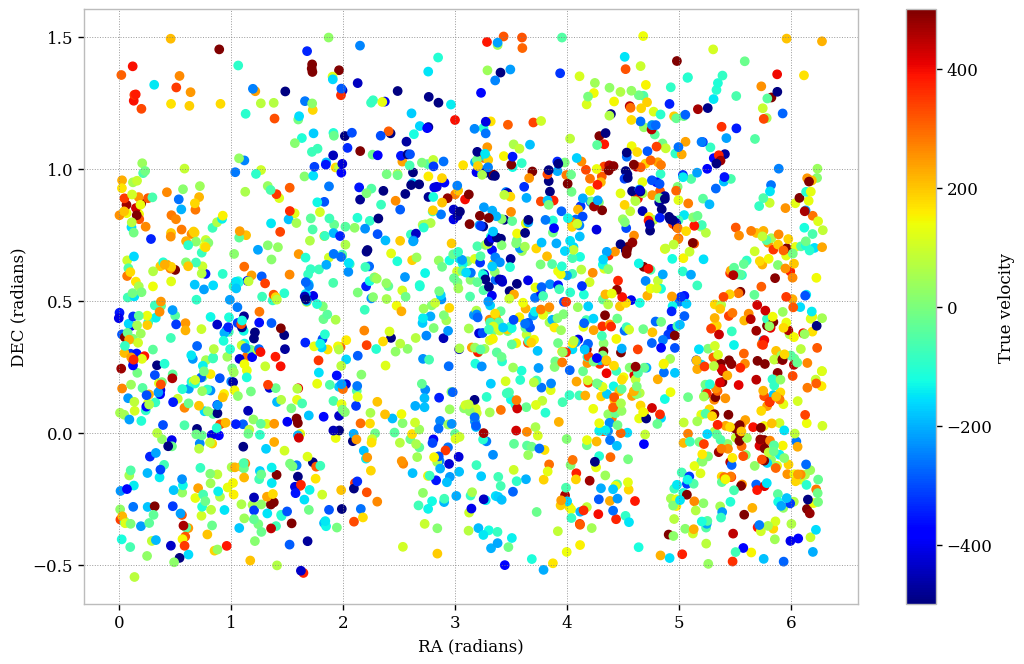

In [5]:
plt.scatter(data_velocity["ra"], data_velocity["dec"],c=data_velocity_true["velocity"],vmin=-500,vmax=500)
plt.xlabel("RA (radians)")
plt.ylabel("DEC (radians)")
cbar = plt.colorbar()
cbar.set_label("True velocity")

In [6]:
print("Available data properties", data_velocity.keys())

Available data properties Index(['zobs', 'mw_r_v', 'mw_ebv', 'sim_t0', 'sim_x1', 'sim_c', 'sim_x0', 'ra',
       'dec', 'zcos', 'zCMB', 'zpec', 'vpec', 'z2cmb', 'sim_mu', 'como_dist',
       'sim_mb', 'mag_sct', 't0', 'x0', 'x1', 'c', 'mb', 'e_t0', 'e_x0',
       'e_mb', 'e_x1', 'e_c', 'cov_x0_x1', 'cov_x0_c', 'cov_x1_c', 'cov_mb_x1',
       'cov_mb_c', 'chi2', 'ndof', 'status', 'rcom_zobs', 'hubble_norm'],
      dtype='object')


Computation of the Hubble diagram from the fitted properties, this is used during the fitting procedure

Text(0.5, 1.0, 'Hubble diagram')

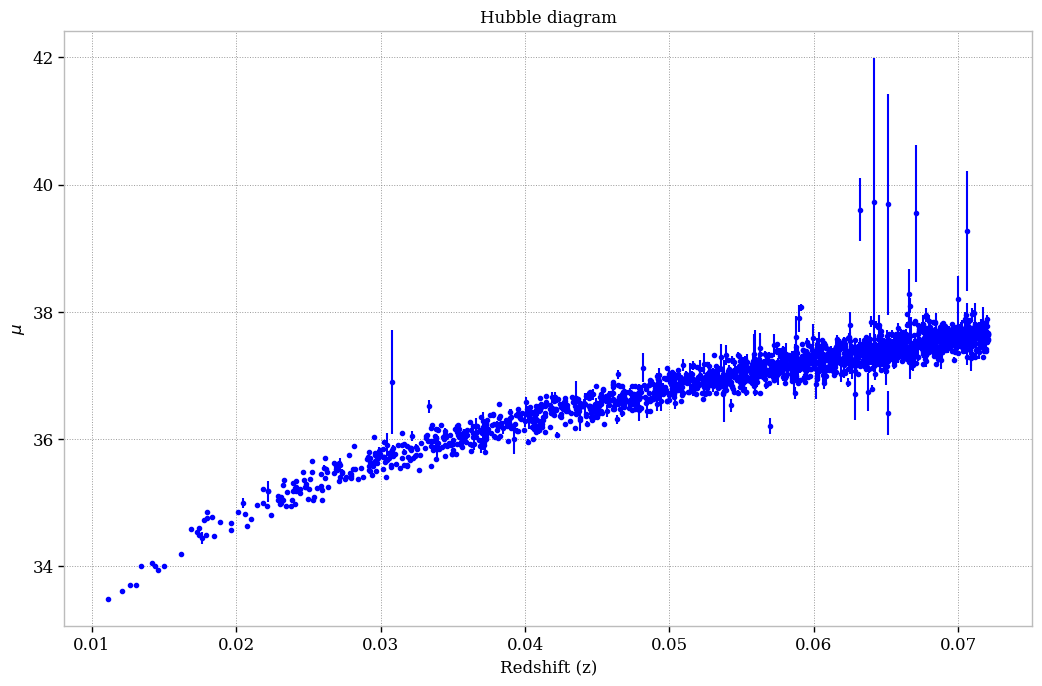

In [7]:
from flip import vectors

test_parameters = {"alpha":0.14,
                   "beta": 3.1,
                   "M_0": -19.133,
                   "sigma_M": 0.12}



mu, variance_mu = vectors.compute_observed_distance_modulus(
        data_velocity,
        test_parameters["alpha"],
        test_parameters["beta"],
        test_parameters["M_0"],
    )
mask = mu > 0
mask &= np.sqrt(variance_mu) - 0.1* mu < 0

plt.errorbar(data_velocity["zobs"][mask], 
             mu[mask], 
             np.sqrt(variance_mu)[mask],
             linestyle="None",
             marker=".")
plt.xlabel("Redshift (z)")
plt.ylabel(r"$\mu$")
plt.title("Hubble diagram")

Compute the estimated velocities and errors from the Hubble diagram properties 

Text(0, 0.5, 'Velocity error')

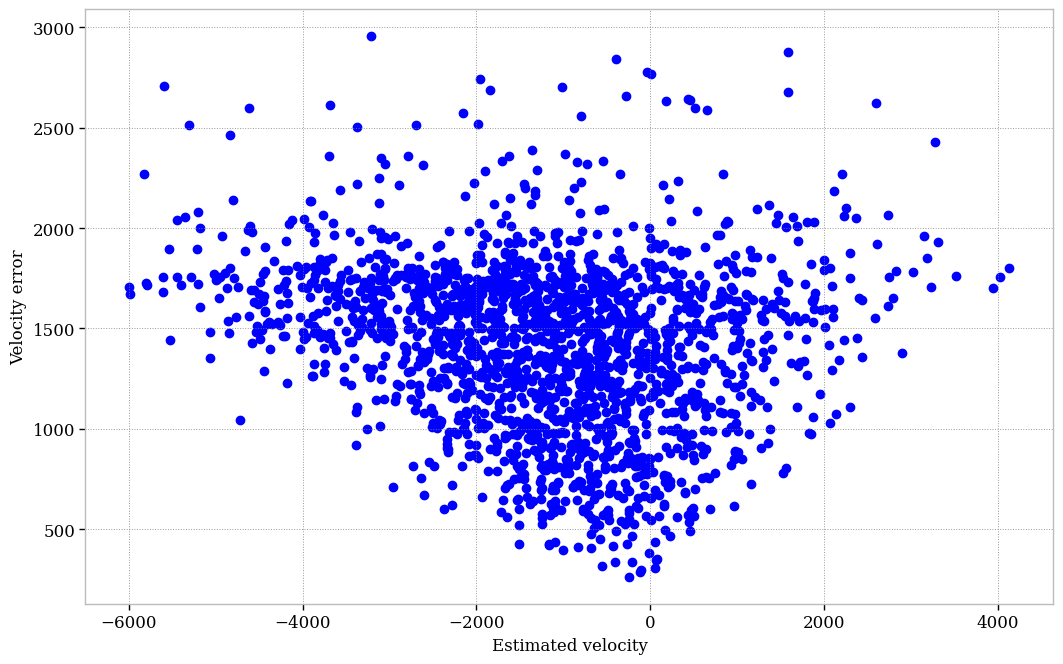

In [8]:

velocity, velocity_error = vectors.get_velocity_from_salt_fit(
    data_velocity,
    test_parameters,
    "full",
)

mask = np.abs(velocity) < 6_000
mask &= velocity_error < 3_000

plt.scatter(velocity[mask], velocity_error[mask])
plt.xlabel("Estimated velocity")
plt.ylabel("Velocity error")

Plot the estimated properties, it is way harder to see the large-scale velocity modes since they are diluted inside the noise 

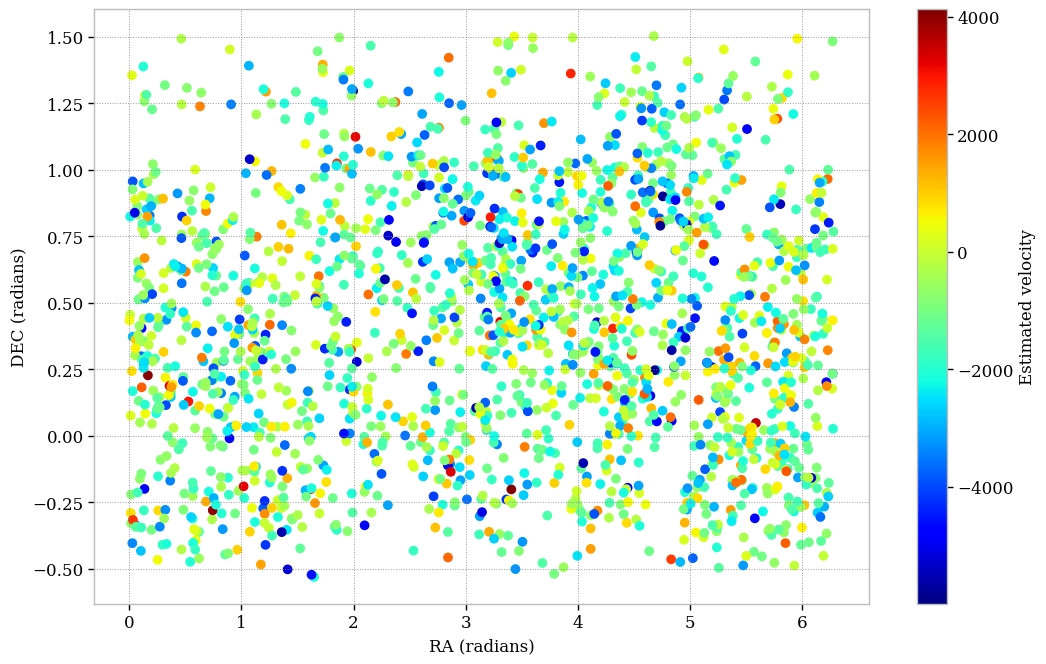

In [9]:
plt.scatter(data_velocity["ra"][mask], data_velocity["dec"][mask],c=velocity[mask])

plt.xlabel("RA (radians)")
plt.ylabel("DEC (radians)")
cbar = plt.colorbar()
cbar.set_label("Estimated velocity")


# Fit true velocity

First part of the flip package: fast computation of the covariance matrix based on theory and SNIa coordinates

In [10]:
size_batch=10_000
number_worker=16


covariance_fit = covariance.CovMatrix.init_from_flip(
    "carreres23",
    "velocity",
    power_spectrum_dict,
    coordinates_velocity=coordinates_velocity,
    size_batch=size_batch,
    number_worker=number_worker,
)


[ 000002.40 ]: 03-01 01:54  root            INFO     Covariance matrix generated from flip with carreres23 model in 9.70e-01 seconds


Second part of the flip package: compute the likelihood, and start the minuit fitter

In [11]:

likelihood_type="multivariate_gaussian"
likelihood_properties = {"inversion_method": "cholesky",
                         "velocity_type": "direct"}


parameter_dict = {"fs8": {"value": 0.4,
                          "limit_low" : 0.0,
                          "fixed" : False,
                         },
                  "sigv": {"value": 200,
                          "limit_low" : 0.0,
                          "fixed" : False,
                         },
                 }



minuit_fitter = fitter.FitMinuit.init_from_covariance(
        covariance_fit,
        data_velocity_true,
        parameter_dict,
        likelihood_type=likelihood_type,
        likelihood_properties = likelihood_properties
)


minuit_fitter.run()


[ 000002.54 ]: 03-01 01:54  root            INFO     Iteration 1/1

[ 000006.55 ]: 03-01 01:54  root            INFO     ┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.374e+04                  │              Nfcn = 33               │
│ EDM = 3.61e-05 (Goal: 0.0002)    │            time = 4.0 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴───────

# Fit true velocity interpolation sigma_u

In the model, there is a sigma_u parameter which can be interpreted to the smoothing of SNIa position due to peculiar velocities. \
To fit simultaneously this parameter, we interpolate the covariance matrix. 

In [12]:
sigmau_list = np.linspace(10.0, 20.0,10)
covariance_list = []
size_batch=10_000
number_worker=16


for sigu in sigmau_list:
    
    power_spectrum_dict = {"vv": [[ktt, ptt* utils.Du(ktt, sigu)**2]]}

    covariance_list.append(covariance.CovMatrix.init_from_flip(
                            "carreres23",
                            "velocity",
                            power_spectrum_dict,
                            coordinates_velocity=coordinates_velocity,
                            size_batch=size_batch,
                            number_worker=number_worker,
    ))


[ 000007.58 ]: 03-01 01:55  root            INFO     Covariance matrix generated from flip with carreres23 model in 1.02e+00 seconds
[ 000008.74 ]: 03-01 01:55  root            INFO     Covariance matrix generated from flip with carreres23 model in 1.16e+00 seconds
[ 000009.76 ]: 03-01 01:55  root            INFO     Covariance matrix generated from flip with carreres23 model in 1.02e+00 seconds
[ 000010.82 ]: 03-01 01:55  root            INFO     Covariance matrix generated from flip with carreres23 model in 1.06e+00 seconds
[ 000011.84 ]: 03-01 01:55  root            INFO     Covariance matrix generated from flip with carreres23 model in 1.02e+00 seconds
[ 000012.91 ]: 03-01 01:55  root            INFO     Covariance matrix generated from flip with carreres23 model in 1.06e+00 seconds
[ 000014.06 ]: 03-01 01:55  root            INFO     Covariance matrix generated from flip with carreres23 model in 1.15e+00 seconds
[ 000015.22 ]: 03-01 01:55  root            INFO     Covariance matri

In [13]:
likelihood_type="multivariate_gaussian_interp1d"
likelihood_properties = {"inversion_method": "cholesky",
                         "velocity_type": "direct"}

parameter_dict = {"fs8": {"value": 0.4,
                          "limit_low" : 0.0,
                          "fixed" : False,
                         },
                  "sigv": {"value": 200,
                          "limit_low" : 0.0,
                          "fixed" : False,
                         },
                  "sigu": {"value": 15.0,
                          "limit_low" : 13.0,
                          "limit_up" : 17.0,
                          "fixed" : False,
                         },
                 }


minuit_fitter_interp = fitter.FitMinuit.init_from_covariance(
        covariance_list,
        data_velocity_true,
        parameter_dict,
        likelihood_type=likelihood_type,
        likelihood_properties = likelihood_properties,
        interpolation_value_name = "sigu",
        interpolation_value_range = sigmau_list,
)


minuit_fitter_interp.run()


[ 000018.63 ]: 03-01 01:55  root            INFO     Iteration 1/1

[ 000066.84 ]: 03-01 01:55  root            INFO     ┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.374e+04                  │              Nfcn = 53               │
│ EDM = 0.000168 (Goal: 0.0002)    │           time = 48.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴───────

# Fit estimate velocity

Let's first apply some simple masks to remove abherant estimated velocities 

In [14]:
test_parameters = {"alpha":0.14,
                   "beta": 3.1,
                   "M_0": -19.133,
                   "sigma_M": 0.12}

velocity, velocity_error = vectors.get_velocity_from_salt_fit(
    data_velocity,
    test_parameters,
    "full",
)

mask = np.abs(velocity) < 3_000
mask &= velocity_error < 3_000

coordinates_velocity_cleaned = np.transpose(np.transpose(coordinates_velocity)[mask])
data_velocity_cleaned = {}
for key in list(data_velocity.keys()):
    data_velocity_cleaned[key] = data_velocity[key][mask]

In [15]:
size_batch=10_000
number_worker=16


covariance_fit = covariance.CovMatrix.init_from_flip(
    "carreres23",
    "velocity",
    power_spectrum_dict,
    coordinates_velocity=coordinates_velocity_cleaned,
    size_batch=size_batch,
    number_worker=number_worker,
)


[ 000067.71 ]: 03-01 01:56  root            INFO     Covariance matrix generated from flip with carreres23 model in 8.54e-01 seconds


In [16]:

likelihood_type="multivariate_gaussian"
likelihood_properties = {"inversion_method": "cholesky",
                         "velocity_type": "saltfit",
                         "velocity_estimator": "full",
                        }


parameter_dict = {"fs8": {"value": 0.4,
                          "limit_low" : 0.0,
                          "limit_up" : 1.0,
                          "fixed" : False,
                         },
                  "sigv": {"value": 200,
                          "limit_low" : 0.0,
                          "limit_up" : 1000,
                          "fixed" : False,
                         },
                  "alpha": {"value": 0.1,
                          "limit_low" : 0.0,
                          "limit_up" : 0.25,
                          "fixed" : False,
                         },
                  "beta": {"value": 3.0,
                          "limit_low" : 2.5,
                          "limit_up" : 4.5,
                          "fixed" : False,
                         },
                  "M_0": {"value": -19,
                          "limit_low" : -21,
                          "limit_up" : -18,
                          "fixed" : False,
                         },
                  "sigma_M": {"value": 0.1,
                          "limit_low" : 0.0,
                          "limit_up" : 100.0,
                          "fixed" : False,
                         }}

minuit_fitter_velest = fitter.FitMinuit.init_from_covariance(
        covariance_fit,
        data_velocity_cleaned,
        parameter_dict,
        likelihood_type=likelihood_type,
        likelihood_properties = likelihood_properties
)


minuit_fitter_velest.run()


/global/homes/r/ravouxco/.local/perlmutter/python-3.11/lib/python3.11/site-packages/iminuit/util.py:172: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
[ 000067.81 ]: 03-01 01:56  root            INFO     Iteration 1/1

[ 000077.90 ]: 03-01 01:56  root            INFO     ┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.415e+04                  │              Nfcn = 207              │
│ EDM = 1.33e-05 (Goal: 0.0002)    │           time = 10.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Bel

# Some plots

Plot of the latest covariance matrix computed 

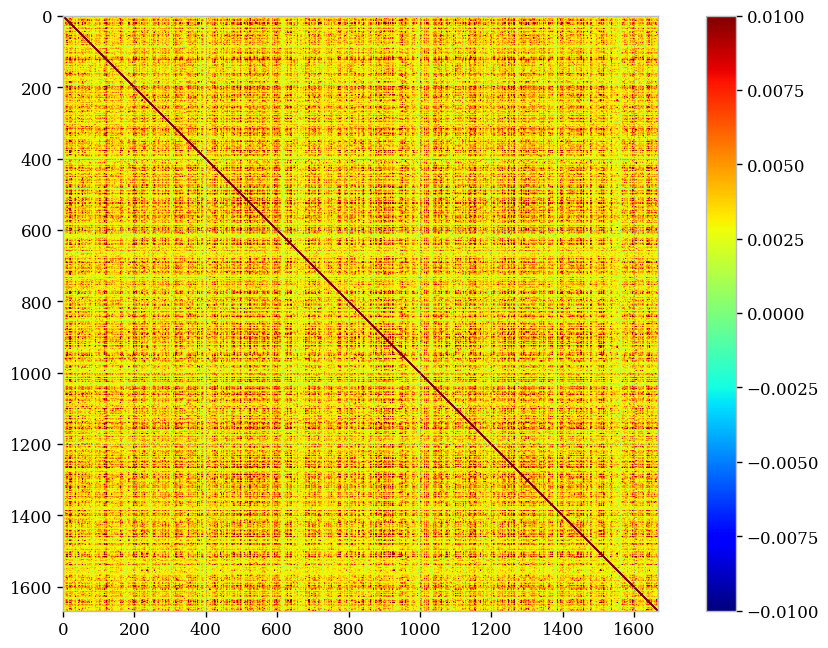

In [17]:
plot_utils.plot_correlation_from_likelihood(
    minuit_fitter_velest.likelihood,
    parameter_dict,
    vmin=-0.01, vmax=0.01
)

The covariance matrix model can be contracted when we consider parallel and perpendicular separations. \
It allows to see the model more clearly:

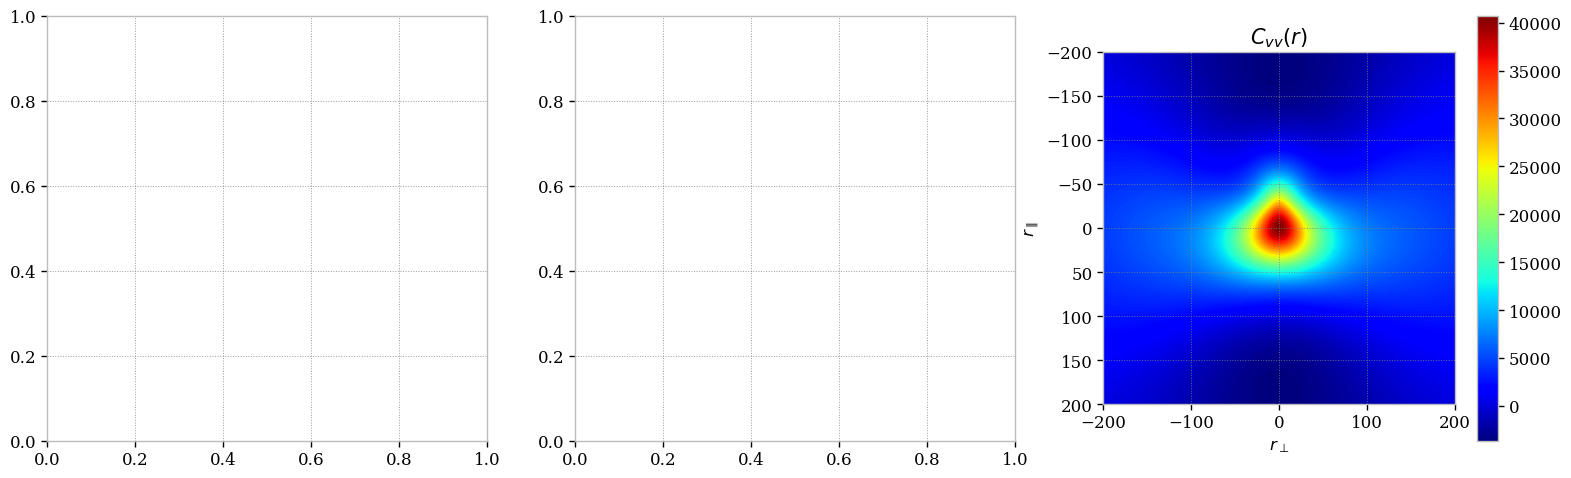

In [18]:

r_perpendicular = np.linspace(-200,200,200)
r_parallel = np.linspace(-200,200,200)

r_reference_parallel = 30 
r_reference_perpendicular = 0 

contraction_plot = contraction.Contraction.init_from_flip(
    "carreres23",
    "velocity",
    power_spectrum_dict,
    r_perpendicular,
    r_parallel,
    r_reference_perpendicular,
    r_reference_parallel,
    coordinate_type="rprt",
)

parameter_values_dict = {parameters: parameter_dict[parameters]["value"] for parameters in parameter_dict}

plot_utils.plot_2d_contraction(contraction_plot, 
                    parameter_values_dict, 
                    rs_multiplied = True)
